<a href="https://colab.research.google.com/github/jtrinquier/SoftAlign/blob/main/COLAB_SoftAlign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
!  pip install git+https://github.com/deepmind/dm-haiku
import numpy as np
import string
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import pandas as pd
import haiku as hk
import os
import re
import Input_MPNN as input_
import END_TO_END_MODELS as ete
import Score_align as score_

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-pjtc1kw9
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-pjtc1kw9
  Resolved https://github.com/deepmind/dm-haiku to commit d14f1b62798a4da47cf3243cd87b1ad7dc52a108
  Preparing metadata (setup.py) ... done
  Created wheel for dm-haiku: filename=dm_haiku-0.0.14.dev0-py3-none-any.whl size=373712 sha256=7e8c83a4c420ad518705e630e61a911d6f97fcc5dc408c98b7ea5bd8a82bb61f
  Stored in directory: /tmp/pip-ephem-wheel-cache-n7uzj92w/wheels/86/29/0a/454c478e7217c383ee3d05aa43cbeff48284c23430f59d0c4f
Successfully built dm-haiku


#tmalign

In [ ]:
%%bash
# get tmscore
wget -qnc https://zhanggroup.org/TM-score/TMscore.cpp
wget -qnc https://zhanggroup.org/TM-align/TMalign.cpp
g++ -static -O3 -ffast-math -lm -o TMscore TMscore.cpp
g++ -static -O3 -ffast-math -lm -o TMalign TMalign.cpp

In [ ]:
import os
def tmscore(x,y):
  x,y = np.asarray(x),np.asarray(y)
  # save to dumpy pdb files
  for n,z in enumerate([x,y]):
    out = open(f"{n}.pdb","w")
    for k,c in enumerate(z):
      out.write("ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n"
                  % (k+1,"CA","ALA","A",k+1,c[0],c[1],c[2],1,0))
    out.close()
  # pass to TMscore
  output = os.popen('./TMscore 0.pdb 1.pdb')
  # parse outputs
  parse_float = lambda x: float(x.split("=")[1].split()[0])
  o = {}
  for line in output:
    line = line.rstrip()
    if line.startswith("RMSD"): o["rms"] = parse_float(line)
    if line.startswith("TM-score"): o["tms"] = parse_float(line)
    if line.startswith("GDT-TS-score"): o["gdt"] = parse_float(line)
  return o

In [ ]:
def tmalign(x,y):
  x,y = np.asarray(x),np.asarray(y)
  # save to dumpy pdb files
  for n,z in enumerate([x,y]):
    out = open(f"{n}.pdb","w")
    for k,c in enumerate(z):
      out.write("ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n"
                  % (k+1,"CA","ALA","A",k+1,c[0],c[1],c[2],1,0))
    out.close()
  # pass to TMscore
  output = os.popen('./TMalign 0.pdb 1.pdb')
  # parse outputs
  parse_float = lambda x: float(x.split("=")[1].split()[0])
  o = {"tms":[]}
  aln = []
  aln_mode = False
  for line in output:
    line = line.rstrip()
    if line.startswith("TM-score"): o["tms"].append(parse_float(line))
    if line.startswith('(":"'): aln_mode = True
    elif aln_mode == True and len(aln) < 3: aln.append(line)
    else: aln_mode = False

  o["aln"] = aln
  aln = []
  a,b = 0,0
  for n in range(len(o["aln"][0])):
    x = o["aln"][0][n]
    y = o["aln"][2][n]
    if x != "-":
      if y != "-": aln.append(b)
      else: aln.append(-1)
    if x != "-": a += 1
    if y != "-": b += 1

  o["aln"] = np.asarray(aln)
  return o

# ALIGN

In [ ]:
pdb1 = "1P9G" # @param {"type":"string"}
pdb2 = "1HEV" # @param {"type":"string"}

os.system("wget -qnc https://files.rcsb.org/view/"+pdb1+".pdb")
os.system("wget -qnc https://files.rcsb.org/view/"+pdb2+".pdb")

0

In [ ]:

X2,mask2,chain2,res2 = input_.get_inputs_mpnn(pdb2+".pdb",chain = 'A')
X1,mask1,chain1,res1 = input_.get_inputs_mpnn(pdb1+".pdb",chain = 'A')

In [ ]:
num_layers = 3 #@param {type:"integer"}
num_neighbors = 64 #@param {type:"integer"}
encoding_dim = 64 #@param {type:"integer"}
categorical = False #@param {type:"boolean"}
nb_clusters = 100 #@param {type:"integer"}
soft_max = False #@param {type:"boolean"}
bs = 15


def model_end_to_end(x1,x2,lens,t,node_features = encoding_dim,
                 edge_features = encoding_dim, hidden_dim = encoding_dim,
                 num_encoder_layers=num_layers,
                  k_neighbors=num_neighbors,categorical = categorical,nb_clusters = nb_clusters,affine = True,soft_max = soft_max):
  if categorical:
    a = ete.END_TO_END_SEQ_KMEANS(node_features,edge_features,hidden_dim,num_encoder_layers,k_neighbors,nb_clusters = nb_clusters,affine = True,soft_max = soft_max,dropout = 0.,augment_eps=0.0)
  else:
    a = ete.END_TO_END(node_features,edge_features,hidden_dim,num_encoder_layers,k_neighbors,affine = True,soft_max = soft_max,dropout = 0.,augment_eps=0.0)
  return a(x1,x2,lens,t)


# _INFERENCE

In [ ]:
## MODEL
key = jax.random.PRNGKey(0)

import pickle
params_path = "CONT_SW_05_T_3_1" #@param {type:"string"}

params= pickle.load(open(params_path,"rb"))


<ipython-input-13-2a9f014bc57b>:7: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  params= pickle.load(open(params_path,"rb"))


In [ ]:
MODEL_ETE = hk.transform(model_end_to_end)
x1 = X1,mask1,chain1,res1
x2 = X2,mask2,chain2,res2
lens = jnp.array([X1.shape[1],X2.shape[1]])[None,:]

### If you want to get softer alignments, change t = 10**-4 to a higher t

soft_aln,sim_matrix,score = MODEL_ETE.apply(params,key, x1,x2,lens,10**-4)

In [ ]:
import Score_align as lddt

mask__1 = np.ones((1,X1.shape[1],X1.shape[1]))
mask__2 = np.ones((1,X2.shape[1],X2.shape[1]))


# LDDT scores

print(lddt.get_LDDTloss(X1[:,:,1],X2[:,:,1],soft_aln,mask__1,mask__2,10**-4))
print(lddt.get_LDDTloss(X2[:,:,1],X1[:,:,1],soft_aln.transpose(0,2,1),mask__2,mask__1,10**-4))

[0.67214906]
[0.64844847]


In [ ]:
aln_tmalign = tmalign(X1[0,:,1],X2[0,:,1])['aln']

In [ ]:
print(tmalign(X1[0,:,1],X2[0,:,1]))

{'tms': [0.63315, 0.61665], 'aln': array([ 0,  1,  2,  3,  7,  8,  9, -1, -1, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       36, 37, 38, 39, 40, 41, -1])}


{'rms': 3.123, 'tms': 0.6109, 'gdt': 0.7683}


<ipython-input-18-c18c7f841b37>:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


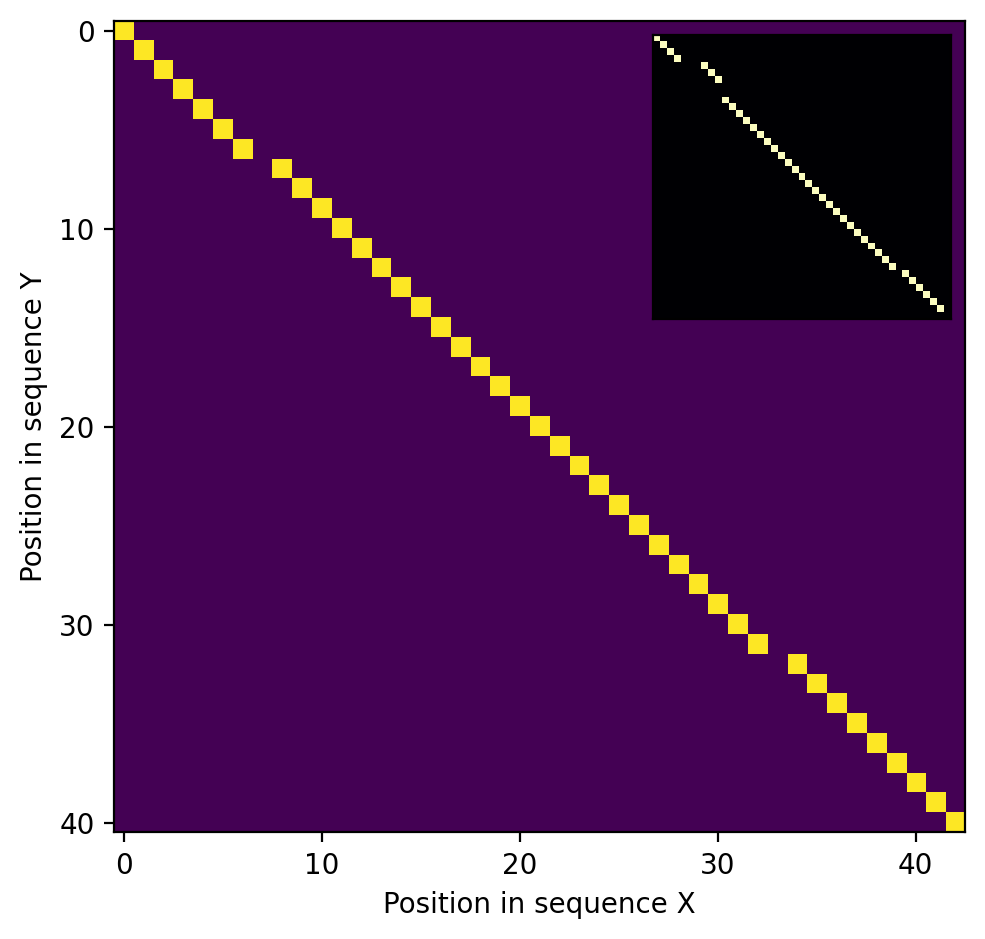

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import jax
import jax.numpy as jnp

# Assuming aln_tmalign, X2, soft_aln, X1, and the tmscore function are defined

# Generate one-hot encoded data
one_hot_data = jax.nn.one_hot(aln_tmalign, X2.shape[1])

# Create the main figure and plot
plt.figure(dpi=200)

# Get the current axis
ax = plt.gca()

# Plot the main soft alignment matrix
plt.imshow(soft_aln[0], aspect='auto')

# Print tmscore (assuming it's defined)
print(tmscore(X1[0,:,1], soft_aln[0] @ X2[0,:,1]))

# Set the axis labels
plt.xlabel("Position in sequence X")
plt.ylabel("Position in sequence Y")

# Get the current axis limits before adjusting ticks
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Set the ticks for x and y axes
ax.set_xticks(range(int(xlim[0]), int(xlim[1])+1, 10))  # X-axis ticks every 10 units
ax.set_yticks(range(int(ylim[1]), int(ylim[0])+1, 10))   # Y-axis ticks every 5 units

# Set the aspect ratio to be equal
ax.set_aspect('equal', adjustable='box')

# Create an inset axis
ax_inset = inset_axes(ax, width="35%", height="35%", loc='upper right')

# Display the one-hot encoded data within the inset axis
ax_inset.imshow(one_hot_data, cmap='magma', aspect='auto')
# Remove ticks from the inset axis
ax_inset.set_xticks([])
ax_inset.set_yticks([])

# Beautify and finalize the plot
plt.tight_layout()
plt.show()


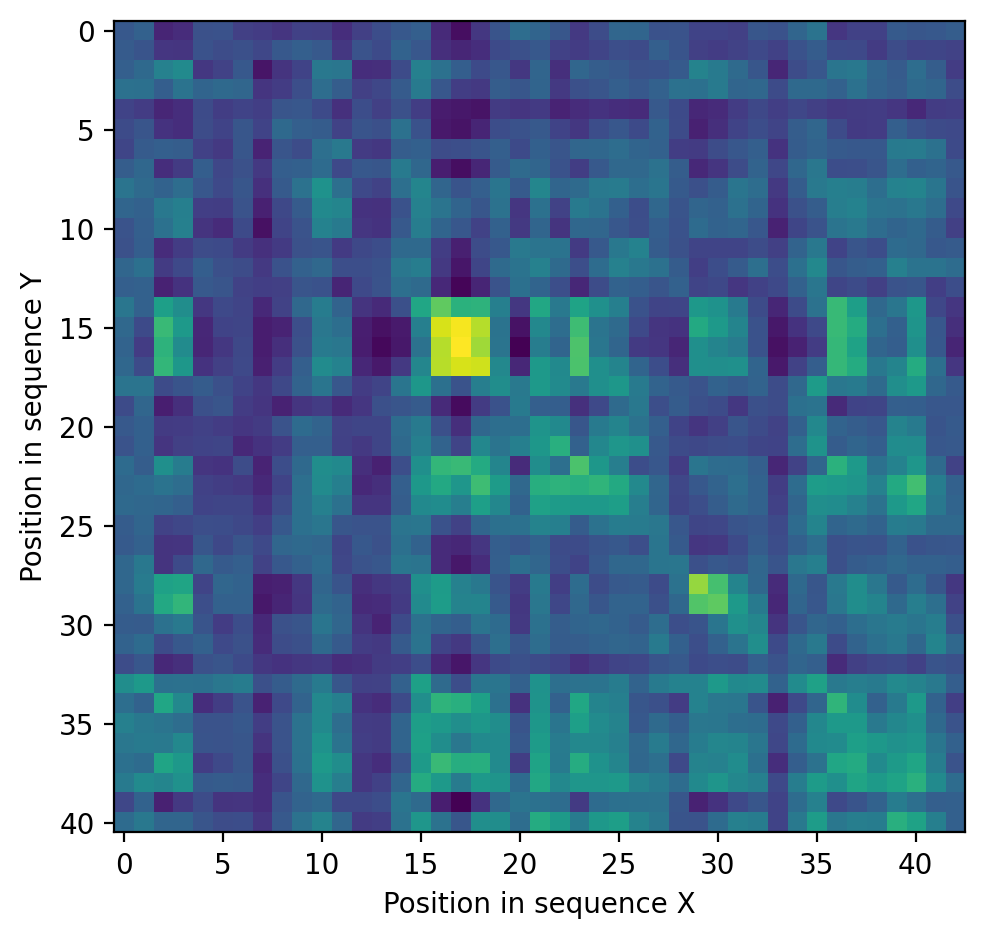

In [ ]:
plt.figure(dpi = 200)
plt.imshow(sim_matrix[0], aspect='auto')
#plt.colorbar()
plt.xlabel("Position in sequence X")
plt.ylabel("Position in sequence Y")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax = plt.gca()



# Set the aspect ratio to be equal
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()